# 2. Figures

Before running this notebook, follow instructions in 1-preprocess.ipynb to preprocess and prepare data for plotting.

## Imports

In [1]:
!pip install --no-cache --quiet regionmask 

In [2]:
from string import ascii_lowercase

import cartopy.crs as ccrs
import dask
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray

import libs.metrics
import libs.plot
import libs.utils
import libs.stats

matplotlib.rcParams.update({ 'font.size': 16 })

## Data + metrics

In [3]:
ds_obs = xarray.open_mfdataset(
    paths='data/obs_processed_2003_2018.nc'
)

ds_clim = xarray.open_mfdataset(
    paths='data/era5_processed_2003_2018.nc'
)
ds_clim_mean = ds_clim\
    .mean('month')\
    .compute()

In [4]:
metrics = [
    {
        'key': 'h_obs',
        'domain': 'global',
        'f': libs.metrics.h_obs,
        'type': 'mixed',
        'title': '$H^{obs}$'
    },
    {
        'key': 'h_w24',
        'domain': 'global',
        'f': libs.metrics.h_w24,
        'type': 'mixed',
        'title': '$H^{W24}$'
    }, {
        'key': 'h_s09',
        'domain': 'global',
        'f': libs.metrics.h_s08,
        'type': 'microbial',
        'title': '$H^{S08}$'
    }, {
        'key': 'h_s16',
        'domain': 'global',
        'f': libs.metrics.h_s16,
        'type': 'complex',
        'title': '$H^{S16}$'
    }, {
        'key': 'h_s19',
        'domain': 'global',
        'f': libs.metrics.h_s19,
        'type': 'complex',
        'title': '$H^{S19}$'
    }, {
        'key': 'h_if',
        'domain': 'marine',
        'f': libs.metrics.h_icefree,
        'type': 'microbial',
        'title': '$H^{IF}$'
    }, {
        'key': 'h_dg19h',
        'domain': 'terrestrial',
        'f': libs.metrics.h_dg19h,
        'type': 'microbial',
        'title': '$H^{DG19H}$'
    }, {
        'key': 'h_dg19na',
        'domain': 'terrestrial',
        'f': libs.metrics.h_dg19na,
        'type': 'microbial',
        'title': '$H^{DG19NA}$'
    } 
]

In [5]:
# Calculate habitability for each metric + observed
for i, metric in enumerate(metrics):
    key = metric['key']

    data_input = ds_obs if key == 'h_obs' else ds_clim_mean
    ds_clim_mean[key] = metric['f'](data_input)

    # Apply masks to terrestrial/marine domains
    if metric['domain'] == 'terrestrial':
        ds_clim_mean[key] = libs.utils.mask_to_land(ds_clim_mean[key])
    elif metric['domain'] == 'marine':
        ds_clim_mean[key] = libs.utils.mask_to_ocean(ds_clim_mean[key])

## Main

### Figure 1

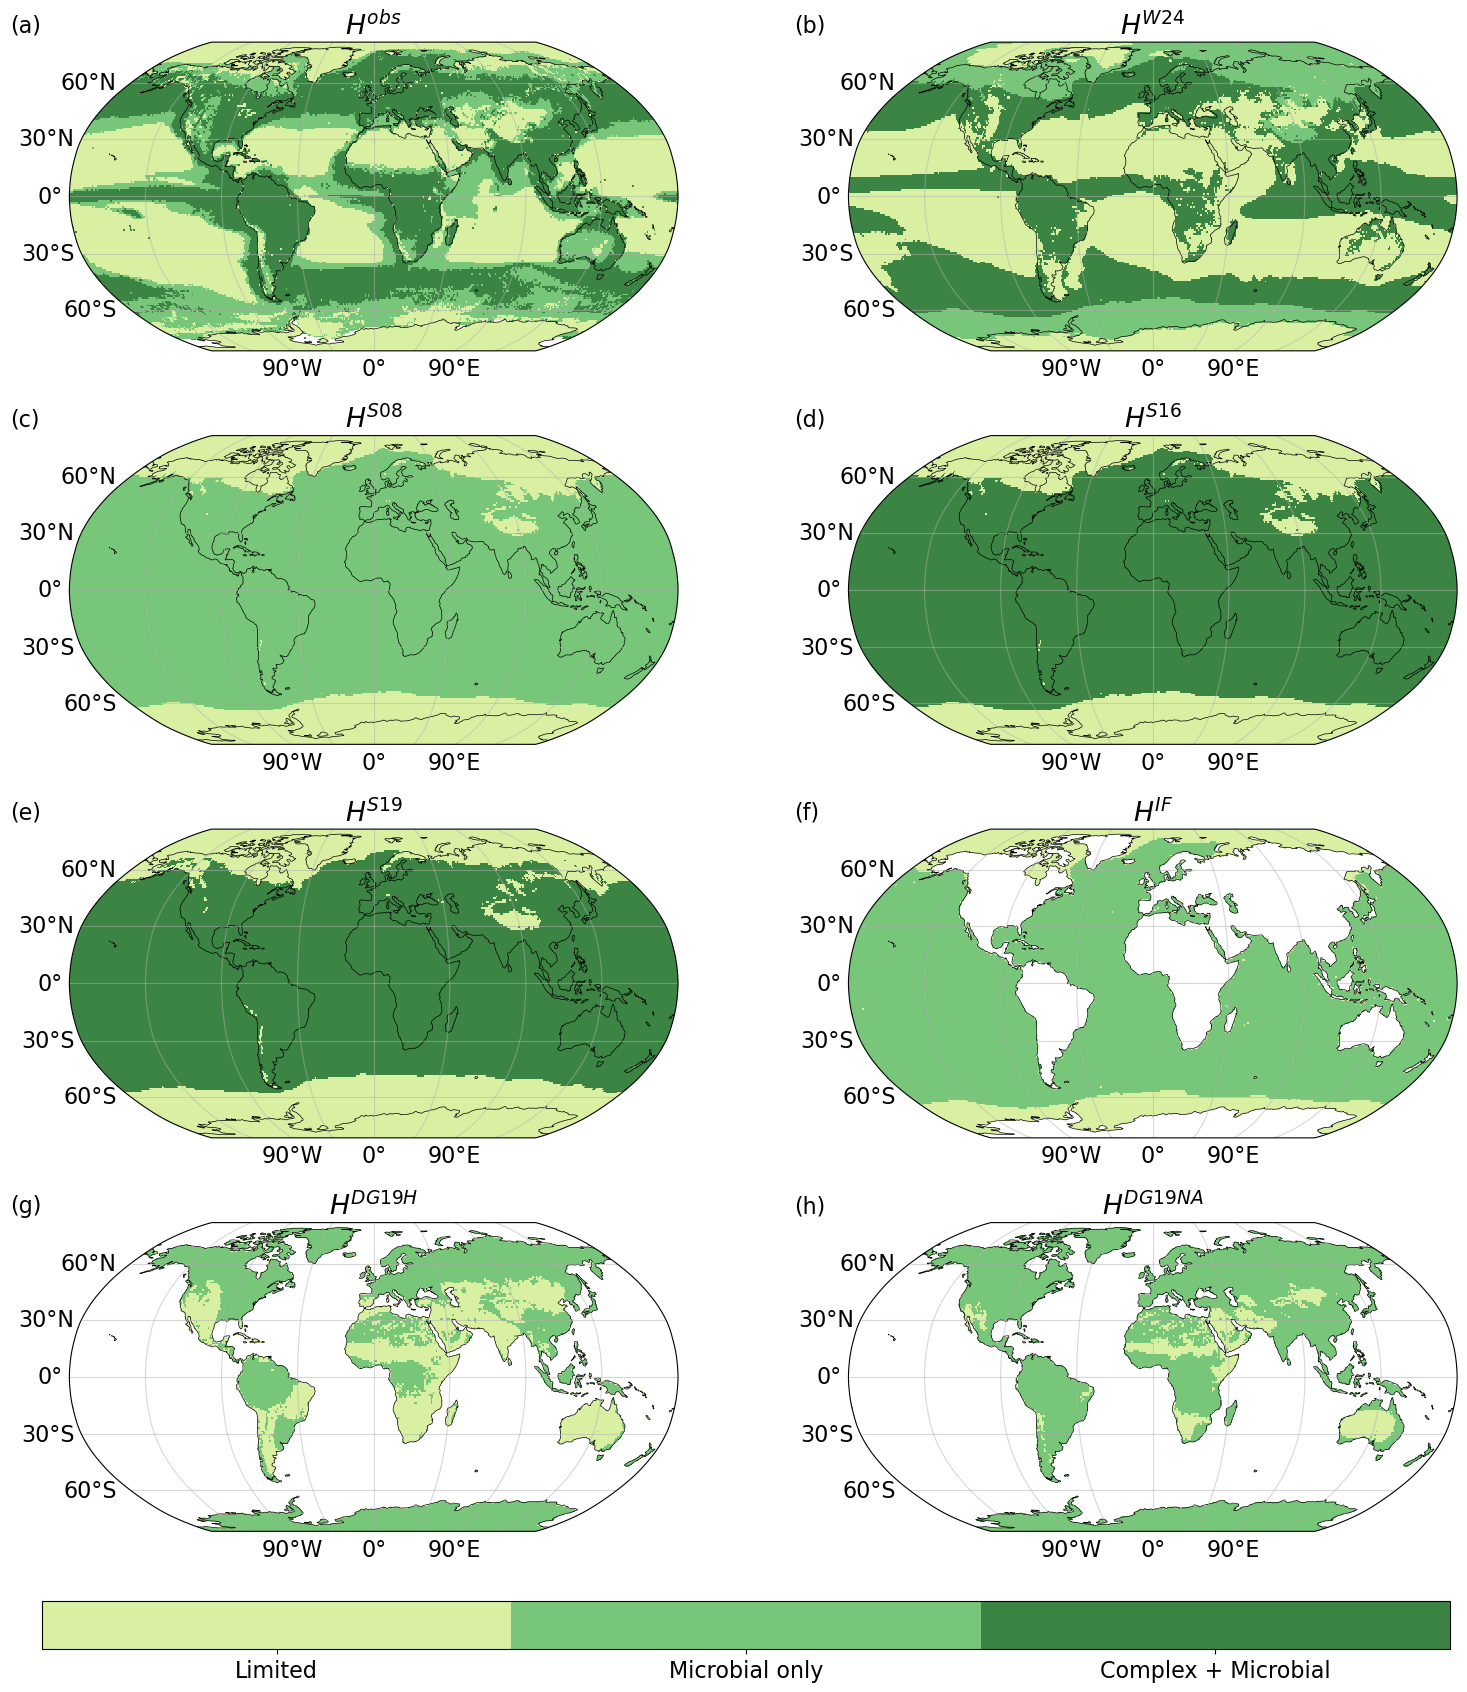

In [6]:
fig, axs = libs.plot.create_fig(
    shape=(4, 2),
    h=4,
    w=8,
)
subfigs = []
subfig_labels = list(ascii_lowercase)

i = 0
for metric in metrics:
    ax = axs[i]
    key = metric['key']

    subfigs.append(
        ds_clim_mean[key].plot(
            add_colorbar=False,
            ax=ax,
            transform=ccrs.PlateCarree(),
            **libs.metrics.get_metric_kwargs()['plot_kwargs']
        )
    )
    
    ax.set_title(metric['title'])
    ax.coastlines(resolution='110m', linewidth=0.5)
    libs.plot.draw_gridlines(ax)

    text_x = 0.04 if i % 2 == 0 else 0.53
    text_y = 0.971 - (np.floor(i / 2) * 0.246)
    fig.text(text_x, text_y, f'({subfig_labels[i]})')
    
    i += 1

fig.tight_layout()

cax = fig.colorbar(
    subfigs[0],
    cax=fig.add_axes([0.06, -0.04, 0.88, 0.03]),
    location='bottom',
    **libs.metrics.get_metric_kwargs()['colorbar_kwargs']
)

cax.set_ticks(libs.metrics.get_metric_kwargs()['colorbar_ticks'])
cax.set_ticklabels(libs.metrics.get_metric_kwargs()['colorbar_ticklabels'])

fig.savefig(
    'figs/fig1-earth-hab.png',
    transparent=True,
    bbox_inches='tight',
    pad_inches=0
);

### Figure A1

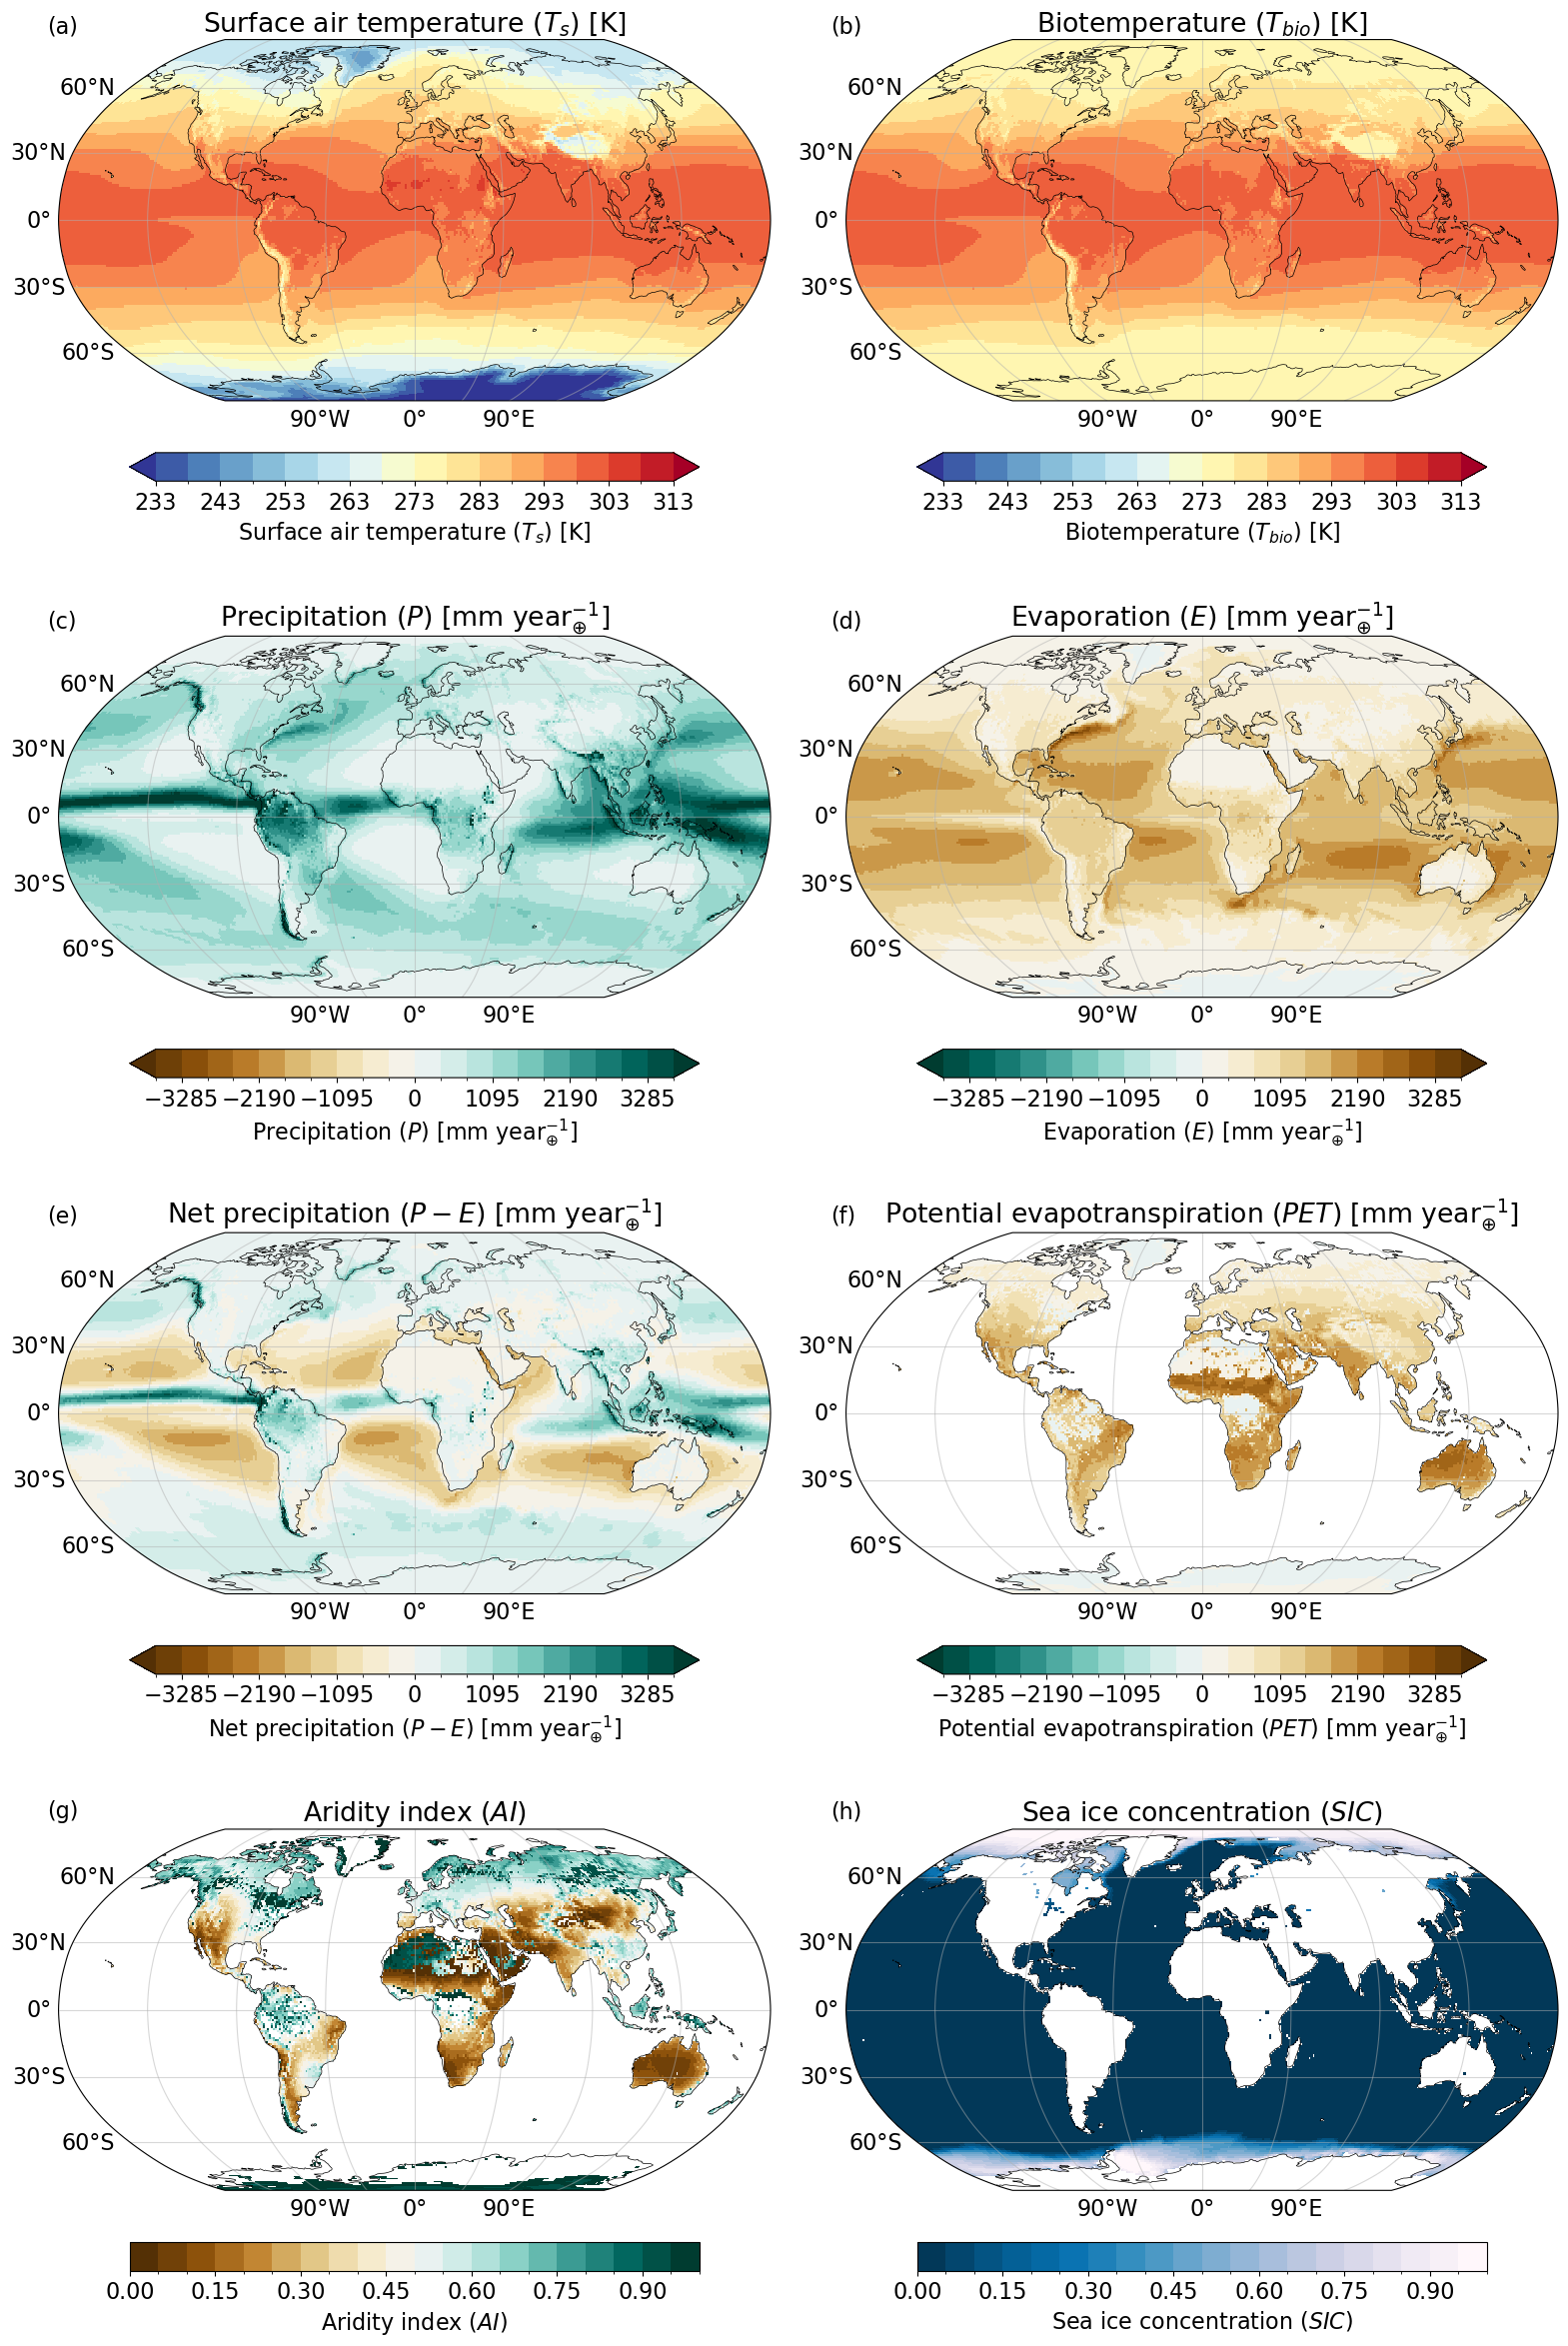

In [7]:
fig, axs = libs.plot.create_fig(
    shape=(4, 2),
    h=6, 
    w=8,
)
subfigs = []
subfig_labels = list(ascii_lowercase)

conf_vars = [
    {
        'key': lambda x: x['tas'],
        'title': 'Surface air temperature ($T_s$) [K]',
        'plot_kwargs': {
            'cmap': 'RdYlBu_r',
            'extend': 'both',
            'levels': np.arange(233, 318, 5)
        }
    },
    {
        'key':  lambda x: x['tbio'],
        'title': 'Biotemperature ($T_{\t{bio}}$) [K]',
        'plot_kwargs': {
            'cmap': 'RdYlBu_r',
            'extend': 'both',
            'levels': np.arange(233, 318, 5)
        }
    },
    {
        'key': lambda x: x['pr'] * 86400.0 * 365,
        'title': 'Precipitation ($P$) [mm year$_{\oplus}^{-1}$]',
        'plot_kwargs': {
            'cmap': 'BrBG',
            'extend': 'both',
            'levels': np.arange(-10, 11, 1) * 365
        }
    },
    {
        'key': lambda x: x['evspsbl'] * 86400.0 * 365,
        'title': 'Evaporation ($E$) [mm year$_{\oplus}^{-1}$]',
        'plot_kwargs': {
            'cmap': 'BrBG_r',
            'extend': 'both',
            'levels': np.arange(-10, 11, 1) * 365
        }
    },
    {
        'key': lambda x: x['prnet'] * 86400.0 * 365,
        'title': 'Net precipitation ($P - E$) [mm year$_{\oplus}^{-1}$]',
        'plot_kwargs': {
            'cmap': 'BrBG',
            'extend': 'both',
            'levels': np.arange(-10, 11, 1) * 365
        }
    },
    {
        'key': lambda x: x['pet'] * 86400.0 * 365,
        'title': 'Potential evapotranspiration ($PET$) [mm year$_{\oplus}^{-1}$]',
        'plot_kwargs': {
            'cmap': 'BrBG_r',
            'extend': 'both',
            'levels': np.arange(-10, 11, 1) * 365
        }
    },
    {
        'key': lambda x: x['ai'],
        'title': 'Aridity index ($AI$)',
        'plot_kwargs': {
            'cmap': 'BrBG',
            'extend': 'neither',
            'levels': np.arange(0, 1.05, 0.05)
        }
    },
    {
        'key': lambda x: x['siconc'],
        'title': 'Sea ice concentration ($SIC$)',
        'plot_kwargs': {
            'cmap': 'PuBu_r',
            'extend': 'neither',
            'levels': np.arange(0, 1.05, 0.05)
        }
    },
]

i = 0
for conf in conf_vars:
    ax = axs[i]
    conf_data = conf['key'](ds_clim_mean)

    subfigs.append(
        conf_data.plot(
            add_colorbar=False,
            ax=ax,
            transform=ccrs.PlateCarree(),
            **conf['plot_kwargs']
        )
    )

    cax = fig.colorbar(
        subfigs[i],
        ax=ax,
        label=conf['title'],
        location='bottom',
        pad=0.1,
        shrink=0.8
    )
    
    ax.set_title(conf['title'])
    ax.coastlines(resolution='110m', linewidth=0.5)
    libs.plot.draw_gridlines(ax)

    text_x = 0.04 if i % 2 == 0 else 0.53
    text_y = 0.975 - (np.floor(i / 2) * 0.248)
    fig.text(text_x, text_y, f'({subfig_labels[i]})')
    
    i += 1

fig.tight_layout()

fig.savefig(
    'figs/supfig1-earth-clim.png',
    transparent=True,
    bbox_inches='tight',
    pad_inches=0
);

## Statistics & fractional habitability

In [8]:
domains = [
    { 'title': 'global', 'filter': lambda data: data },
    { 'title': 'marine', 'filter': libs.utils.mask_to_ocean },
    { 'title': 'terrestrial', 'filter': libs.utils.mask_to_land },
]
cats = ['microbial', 'complex']

obs_data = ds_clim_mean['h_obs']

for domain in domains:
    print('-' * 20)
    print(f'- {domain["title"]}')

    for metric in metrics:
        key = metric['key']
        print(f'--- {key}')
        pred_data = ds_clim_mean[key]
        pred_data_filtered = domain['filter'](pred_data)
        h_frac = libs.metrics.calc_hab_fractions(pred_data_filtered)
        
        for type in cats:
            h_frac_type = f'{h_frac[type]:.2f}'
        
            if key == 'h_obs':
                print(
                f'----- {type}',
                    f'fH={h_frac_type}',
                    sep=' | '
                )
                    
                continue
            if (metric['domain'] != 'global') and (metric['domain'] != domain['title']):
                print(
                    f'----- {type}',
                    'n/a',
                    sep=' | '
                )

                continue
            if (metric['type'] != 'mixed') and (metric['type'] != type):
                print(
                    f'----- {type}',
                    'n/a',
                    sep=' | '
                )
                
                continue
    
            ctable, f_skill_score = libs.stats.get_ctable(
                obs_data,
                pred_data_filtered,
                type=type
            )
            ss = f_skill_score(ctable)        
            try:
                chi2 = scipy.stats.chi2_contingency(ctable)
                chi2_text = f'chisq={chi2.statistic:.0f}, p={chi2.pvalue:.4f}, dof={chi2.dof}'
            except:
                chi2_text = ''

            print(
                f'----- {type}',
                f'pc={ss["pc"]:.2f}',
                f'hss={ss["hss"]:.2f}',
                chi2_text,
                f'fH={h_frac_type}',
                sep=' | '
            )

--------------------
- global
--- h_obs
----- microbial | fH=0.59
----- complex | fH=0.36
--- h_w24
----- microbial | pc=0.67 | hss=0.34 | chisq=4906, p=0.0000, dof=1 | fH=0.53
----- complex | pc=0.70 | hss=0.36 | chisq=5455, p=0.0000, dof=1 | fH=0.41
--- h_s09
----- microbial | pc=0.59 | hss=0.05 | chisq=135, p=0.0000, dof=1 | fH=0.85
----- complex | n/a
--- h_s16
----- microbial | n/a
----- complex | pc=0.46 | hss=0.10 | chisq=1333, p=0.0000, dof=1 | fH=0.85
--- h_s19
----- microbial | n/a
----- complex | pc=0.47 | hss=0.10 | chisq=990, p=0.0000, dof=1 | fH=0.82
--- h_if
----- microbial | n/a
----- complex | n/a
--- h_dg19h
----- microbial | n/a
----- complex | n/a
--- h_dg19na
----- microbial | n/a
----- complex | n/a
--------------------
- marine
--- h_obs
----- microbial | fH=0.55
----- complex | fH=0.29
--- h_w24
----- microbial | pc=0.64 | hss=0.28 | chisq=2250, p=0.0000, dof=1 | fH=0.49
----- complex | pc=0.66 | hss=0.25 | chisq=1898, p=0.0000, dof=1 | fH=0.40
--- h_s09
----- m